In [1]:
# Load Data
import pandas as pd
import numpy as np

dataset = pd.read_csv('export_data.csv', header = 0)
dataset.set_index(dataset.columns[0], inplace=True)
print(dataset[:5])

# Convert to numpy array
np_dataset = np.array(dataset)
print(np_dataset.shape) # 40152, 6
print(np_dataset[:5])

# divide the dataset into three categories: train, validation, test

train_data = np_dataset[:25000]
validation_data = np_dataset[25001:30000]
test_data = np_dataset[30001:40152]


                  Temp (°C)  Dew Point Temp (°C)  Rel Hum (%)  \
Date/Time                                                       
2015-01-01 00:00       -5.9                -11.8         63.0   
2015-01-01 01:00       -5.9                -13.6         54.0   
2015-01-01 02:00       -6.1                -14.2         53.0   
2015-01-01 03:00       -5.8                -13.2         56.0   
2015-01-01 04:00       -5.7                -11.9         62.0   

                  Wind Dir (10s deg)  Wind Spd (km/h)  Stn Press (kPa)  
Date/Time                                                               
2015-01-01 00:00                26.0             28.0           100.21  
2015-01-01 01:00                26.0             21.0           100.19  
2015-01-01 02:00                26.0             27.0           100.17  
2015-01-01 03:00                25.0             28.0           100.14  
2015-01-01 04:00                25.0             24.0           100.14  
(40152, 6)
[[ -5.9  -11.8   63.  

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
%matplotlib inline


batch_size = 100
num_epochs = 20
learning_rate = 0.00003

In [3]:
class Dataset(Dataset):
    def __init__(self, data, mode, mean=None, std=None, seq_len=480, target_delay=24, stride=5, normalize=True):
        self.mode = mode
        self.seq_len = seq_len
        self.target_delay = target_delay
        self.stride = stride
        self.data = data
        if mode == 'train':
            assert (mean is None) and (std is None), \
                "Argument should be None on train mode"
            self.mean = np.mean(data, axis=0)
            self.std = np.std(data, axis=0) 
        else:
            assert (mean is not None) and (std is not None), \
                "You can use mean/std from train_data"
            self.mean = mean
            self.std = std
        
        if normalize:
            self.data = (self.data - self.mean) / self.std
    
    def __getitem__(self, index):
        index = index * self.stride
        sequence = self.data[index:index + self.seq_len, :]
        # print(sequence.shape) (480,9)
        target = self.data[index+self.seq_len+self.target_delay-1, 0]
        target = np.expand_dims(target, axis=0)
        # print(target.shape) (1,)
        return sequence, target
    
    def __len__(self):
        max_idx = len(self.data) - self.seq_len - self.target_delay
        num_of_idx = max_idx // self.stride
        return num_of_idx

In [4]:
train_data = Dataset(train_data, 'train', mean=None, std=None)
val_data = Dataset(validation_data, 'val', mean=train_data.mean, std=train_data.std)
test_data = Dataset(test_data, 'test', mean=train_data.mean, std=train_data.std)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

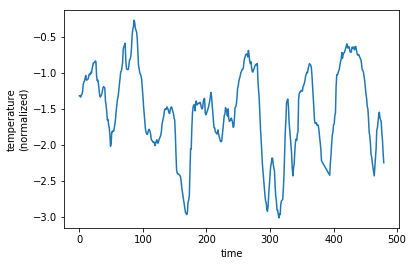

In [5]:
temp = train_data[0][0]
temp = temp[:, 0]
plt.plot(range(len(temp)), temp)
plt.xlabel('time')
plt.ylabel('temperature\n(normalized)')
plt.show()

In [6]:
def eval_baseline(data_loader, criterion):
    total_loss = 0
    cnt = 0
    for step, (sequence, target) in enumerate(data_loader):
        ## 코드 시작 ##
        # print("seq", sequence.shape) torch.Size([100, 480, 9]) # batch_size = 100
        pred = sequence[:, -1:, :1]        # 위의 설명 1. 을 참고하여 None을 채우세요.
        # print("pred", pred.shape) # torch.Size([100, 1, 1])
        pred = torch.squeeze(pred, 1)
        # print("pred", pred.shape) # torch.Size([100, 1])
        # print("tar", target.shape) torch.Size([100, 1])
        loss = criterion(pred, target)       # 위의 설명 2. 를 참고하여 None을 채우세요.
        ## 코드 종료 ##
    
        total_loss += loss
        cnt += 1
    avrg_loss = total_loss / cnt
    print('Baseline Average Loss: {:.4f}'.format(avrg_loss))
    return avrg_loss.item()

In [7]:
baseline_loss = eval_baseline(test_loader, nn.MSELoss())

Baseline Average Loss: 0.1864


In [9]:
for i in range(15):
    data_idx = np.random.randint(len(test_data))
    pred = test_data[data_idx][0][-1, 0]
    pred = pred * test_data.std[0] + test_data.mean[0]  # un-normalization
    target = test_data[data_idx][1][0] * test_data.std[0] + test_data.mean[0] # un-normalization
    print('Predicted Temp: {:.1f} / Actual Temp: {:.1f}'.format(pred, target))

Predicted Temp: 15.9 / Actual Temp: 19.0
Predicted Temp: 22.8 / Actual Temp: 24.1
Predicted Temp: -9.6 / Actual Temp: 2.9
Predicted Temp: -6.8 / Actual Temp: -6.0
Predicted Temp: -3.4 / Actual Temp: -7.3
Predicted Temp: 5.8 / Actual Temp: 4.2
Predicted Temp: 22.2 / Actual Temp: 23.2
Predicted Temp: -7.8 / Actual Temp: 0.9
Predicted Temp: -13.3 / Actual Temp: -11.7
Predicted Temp: 10.2 / Actual Temp: 11.3
Predicted Temp: 8.9 / Actual Temp: 12.2
Predicted Temp: 8.1 / Actual Temp: 6.4
Predicted Temp: 11.7 / Actual Temp: 8.3
Predicted Temp: 23.0 / Actual Temp: 24.4
Predicted Temp: 21.9 / Actual Temp: 23.3


In [20]:
class SimpleLSTM(nn.Module):
    def __init__(self, hidden_size=100, num_layers=1):
        super().__init__()
        self.input_size = 6
        self.output_size = 1
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True) # 위의 설명 1. 을 참고하여 None을 채우세요.
        self.fc = nn.Linear(self.hidden_size, self.output_size) # 위의 설명 2. 를 참고하여 None을 채우세요.

    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size) # 위의 설명 3. 을 참고하여 None을 채우세요.
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size) # 위의 설명 3. 을 참고하여 None을 채우세요.
        return hidden, cell
    
    def forward(self, x):
        # hidden, cell state init
        h, c = self.init_hidden(x.size(0))
        h, c = h.to(x.device), c.to(x.device)
        out, (h, c) = self.lstm(x, (h, c))     
        final_output = self.fc(out[:, -1:, :])     
        final_output = torch.squeeze(final_output, dim = 1) # shape (100,1)

        return final_output

In [21]:
def train(num_epochs, model, data_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    for epoch in range(num_epochs):
        for step, (sequence, target) in enumerate(data_loader):
            sequence = sequence.type(torch.float32)
            target = target.type(torch.float32)
            sequence, target = sequence.to(device), target.to(device)

            outputs = model(sequence)  
            loss = criterion(outputs, target)     
            optimizer.zero_grad() 
            loss.backward()       
            optimizer.step()       
            
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
                
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [22]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        for step, (sequence, target) in enumerate(data_loader):
            sequence = sequence.type(torch.float32)
            target = target.type(torch.float32)
            sequence, target = sequence.to(device), target.to(device)

            outputs = model(sequence)  
            loss = criterion(outputs, target)

            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}'.format(epoch, avrg_loss))
    model.train()
    return avrg_loss

In [30]:
def test(model, data_loader, criterion, baseline_loss, device):
    print('Start test..')
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        for step, (sequence, target) in enumerate(data_loader):
            sequence = sequence.type(torch.float32)
            target = target.type(torch.float32)
            sequence, target = sequence.to(device), target.to(device)
            # print(sequence.shape) 100,480,9
            outputs = model(sequence) 
            loss = criterion(outputs, target)   
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        print('Test  Average Loss: {:.4f}  Baseline Loss: {:.4f}'.format(avrg_loss, baseline_loss))
        
    if avrg_loss < baseline_loss:
        print('Above baseline performance!')
    else:
        print('Below baseline performance')

In [27]:
def save_model(model, saved_dir, file_name='best_model.pt'):
    import os
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {
        'net': model.state_dict()
    }
    output_path = os.path.join(saved_dir, file_name)
    torch.save(check_point, output_path)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu" 

In [25]:
torch.manual_seed(7777) 
model = SimpleLSTM()          
model = model.to(device)
criterion = nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)     
val_every = 1
saved_dir = './saved/LSTM'

In [18]:
batch_size = 100
num_epochs = 20
learning_rate = 0.00003

In [28]:
train(num_epochs, model, train_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/20], Step [25/48], Loss: 0.9349
Start validation #1
Validation #1  Average Loss: 1.4686
Best performance at epoch: 1
Save model in ./saved/LSTM
Epoch [2/20], Step [25/48], Loss: 0.8762
Start validation #2
Validation #2  Average Loss: 1.3847
Best performance at epoch: 2
Save model in ./saved/LSTM
Epoch [3/20], Step [25/48], Loss: 0.9227
Start validation #3
Validation #3  Average Loss: 1.2853
Best performance at epoch: 3
Save model in ./saved/LSTM
Epoch [4/20], Step [25/48], Loss: 0.6388
Start validation #4
Validation #4  Average Loss: 1.1513
Best performance at epoch: 4
Save model in ./saved/LSTM
Epoch [5/20], Step [25/48], Loss: 0.5428
Start validation #5
Validation #5  Average Loss: 0.9628
Best performance at epoch: 5
Save model in ./saved/LSTM
Epoch [6/20], Step [25/48], Loss: 0.4483
Start validation #6
Validation #6  Average Loss: 0.6519
Best performance at epoch: 6
Save model in ./saved/LSTM
Epoch [7/20], Step [25/48], Loss: 0.3356
Start validation #7
Vali

In [29]:
model_path = './saved/LSTM/best_model.pt'
model = SimpleLSTM().to(device) 

checkpoint = torch.load(model_path)    
state_dict = checkpoint['net']   
model.load_state_dict(state_dict) 

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [31]:
test(model, test_loader, criterion, baseline_loss, device)

Start test..
Test  Average Loss: 0.1615  Baseline Loss: 0.1864
Above baseline performance!


In [33]:
for i in range(15):
    data_idx = np.random.randint(len(test_data))
    sequence = test_data[data_idx][0]
    sequence = torch.Tensor(sequence).unsqueeze(0).to(device)
    #print(sequence.shape)
    pred = model(sequence)
    pred = pred.item() * test_data.std[0] + test_data.mean[0]
    
    target = test_data[data_idx][1][0] * test_data.std[0] + test_data.mean[0]
    print('Prediction: {:.1f} / Actual Temperature: {:.1f}'.format(pred, target))

Prediction: -4.5 / Actual Temperature: -5.2
Prediction: -4.4 / Actual Temperature: -8.6
Prediction: 21.2 / Actual Temperature: 19.9
Prediction: -4.7 / Actual Temperature: -14.7
Prediction: 20.8 / Actual Temperature: 24.8
Prediction: -5.6 / Actual Temperature: -10.7
Prediction: 16.3 / Actual Temperature: 24.2
Prediction: -11.7 / Actual Temperature: -23.2
Prediction: 12.0 / Actual Temperature: 16.8
Prediction: 1.2 / Actual Temperature: 6.1
Prediction: 23.1 / Actual Temperature: 24.1
Prediction: -3.1 / Actual Temperature: -11.7
Prediction: -7.8 / Actual Temperature: -13.3
Prediction: 2.9 / Actual Temperature: 0.4
Prediction: 7.5 / Actual Temperature: 5.1
